In [ ]:
import tensorflow as tf
import numpy as np
# Tensorflow Dist
import tensorflow_probability as tfp
tfd = tfp.distributions

from collections import deque # Used to have limited arrays

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import os
import re   #regex
import time
import datetime
#import json
#import gc # Garbage collector of Python


from datetime import datetime
from google.colab import drive
# Libs for Images
from PIL import Image
import imageio

import glob #it does pattern matching and expansion <- Retrieving filenames on system and such
#from tensorflow.keras.preprocessing.image import ImageDataGenerator


#import itertools
#from sklearn.metrics import confusion_matrix , classification_report

# Manipulate the cells output
from IPython import display

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED) 
# Easy life 
tensorboard_loaded = False


#Google Drive
drive.mount('/content/drive')
# Path settings
base_path = '/content/drive/My Drive/'
path_to_TrackGAN = base_path + 'Colab Notebooks/TrackGAN/'
# Custom Libraries Path
import sys
sys.path.append(base_path + 'Libs')


# Configure the logging
import logging 
logging.basicConfig( level=logging.DEBUG)
#logging.basicConfig(format=formatter, level=logging.DEBUG)


# Reloading Custom Libraries
import importlib

# Custom Libraries Import
import keras_utils
import keras_models
import image_utils
import train_asses
import data_utils
import custom_metrics


Mounted at /content/drive


DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [ ]:
def rlib():
  libs = [keras_utils , keras_models , image_utils, train_asses, data_utils , custom_metrics]
  for lib in libs:
    importlib.reload(lib)

In [ ]:
#cwd = os.getcwd()

from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X_ = np.concatenate((x_train, x_test), axis=0)
Y_ = np.concatenate((y_train, y_test), axis=0)

X_ = X_.reshape(X_.shape[0], 28, 28, 1).astype('float32')

X_.shape
print()
Y_.shape



11501568/11490434 [==============================] - 0s 0us/step


(70000, 28, 28, 1)

(70000,)

In [ ]:
image = np.zeros( shape = [20,20,3])
red_image = np.zeros_like(image)
red_image[2:8,2:8,0] = 1

blue_image = np.zeros_like(image)
blue_image[7:14,7:14,2] = tf.random.normal( blue_image[7:14,7:14,2].shape , 0.8, 0.05, tf.float32)

green_image = np.zeros_like(image)
green_image[0:14,10:20,1] = 1


In [ ]:
# Create Fake Dataset FOR TESTING RELATIVE DATA DISTRIBUTION

image = np.zeros( shape = [28,28,3])

X_ = np.zeros( shape = [90,28,28,3] )
Y_ = np.zeros( shape = [90,1] )


# RED IMAGES
X_[:30,2:14,2:14,0] = tf.random.normal( X_[:30,2:14,2:14,0].shape, 160, 10, tf.float32)
Y_[:30] = 0
# GREEN
X_[30:60,0:14,14:28,1] = tf.random.normal( X_[30:60,0:14,14:28,1].shape, 160, 10, tf.float32)
Y_[30:60] = 1
# BLUE
X_[60:90,10:20,10:20,2] = tf.random.normal( X_[60:90,10:20,10:20,2].shape, 160, 10, tf.float32)
Y_[60:90] = 2

X_.shape
Y_.shape

(90, 28, 28, 3)

(90, 1)

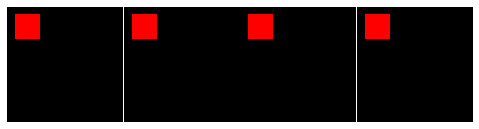

In [ ]:
#image_utils.display_image(red_image)
#image_utils.display_multiple_image( [red_image, green_image, blue_image], size = [600,300])
image_utils.display_multiple_image( X_[:4], size = [600,300])

In [ ]:
BATCH_SIZE = 10
BUFFER_SIZE = X_.shape[0]

training_dataset = tf.data.Dataset.from_tensor_slices((X_,Y_))
# Normalize
training_dataset = training_dataset.map(image_utils.normalize_image)
# To One Hot
#training_dataset = training_dataset.map(train_asses.to_one_hot_encode)
# Batch and shuffle the data
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True) # In Order to have the same batch Dimension, without a repeat dataset - To change  


valid_dataset = tf.data.Dataset.from_tensor_slices((X_[-BATCH_SIZE:],Y_[-BATCH_SIZE:]))
# Normalize
valid_dataset = valid_dataset.map(image_utils.normalize_image)
# To One Hot
#valid_dataset = valid_dataset.map(train_asses.to_one_hot_encode)
# To Batch
valid_dataset = valid_dataset.batch(BATCH_SIZE)


training_dataset
print()
valid_dataset

<BatchDataset element_spec=(TensorSpec(shape=(10, 28, 28, 3), dtype=tf.float64, name=None), TensorSpec(shape=(10, 1), dtype=tf.float64, name=None))>

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

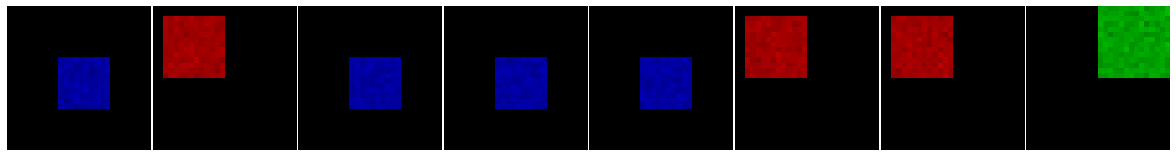

In [ ]:
for x,y in training_dataset:
  image_utils.display_multiple_image(x[:8] , size=[1500,2000] , denormalize=True)
  break

In [ ]:
rlib()
epsilon = 1e-3

# Original Data
mean_per_px , std_per_px = image_utils.get_mean_std_per_pixel(X_)
mean_per_channel , std_per_channel = image_utils.get_mean_std_per_channel(X_)

mean_per_patch_channel , std_per_patch_channel = image_utils.get_mean_std_per_patch(X_ , patch_shape  = [2,2] , patch_type = 'channel' )


px_dist = tfd.Normal(loc=mean_per_px+epsilon, scale=std_per_px+epsilon)
ch_px_dist = tfd.Normal(loc=mean_per_channel+epsilon, scale=std_per_channel+epsilon)
patch_ch_px_dist = tfd.Normal(loc=mean_per_patch_channel+epsilon, scale=std_per_patch_channel+epsilon)

In [ ]:
rlib()
#mean_per_px , std_per_px = image_utils.get_mean_std_per_pixel(X_ + 13) # skewed
#avg_log_loss_res = train_asses.extract_distribution_log_losses(distributions , X_ + 13)
#print()
log_loss, kl_div = train_asses.extract_distribution_losses(distributions , X_- epsilon)
print()
log_loss, kl_div = train_asses.extract_distribution_losses(distributions , X_)
print()



In [ ]:
distributions = {"Distribution per Pixel" : px_dist , "Distribution Per Channel" : ch_px_dist , "Distribution Per (2,2) Patch" :  patch_ch_px_dist}
distributions

{'Distribution Per (2,2) Patch': <tfp.distributions.Normal 'Normal' batch_shape=[14, 14, 3] event_shape=[] dtype=float32>,
 'Distribution Per Channel': <tfp.distributions.Normal 'Normal' batch_shape=[28, 28, 3] event_shape=[] dtype=float64>,
 'Distribution per Pixel': <tfp.distributions.Normal 'Normal' batch_shape=[28, 28] event_shape=[] dtype=float64>}

In [ ]:
rlib()
image_utils.plot_channels_dist( [ch_px_dist,ch_px_dist], image_channels = 1, title = ["Original Data Color Per Channel Distribution" , "Gen Data Color Per Channel Distribution"] )

In [ ]:
rlib()
keras_models.make_conditioned_generator_model().summary()
keras_models.make_conditioned_discriminator_model().summary()

In [ ]:
rlib()
#keras_models.define_generator(latent_dim = 100).summary()
#keras_models.define_discriminator().summary()
keras_models.define_discriminator_rgb().summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 1, 50)        500         ['input_21[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 1, 2352)      119952      ['embedding_10[0][0]']           
                                                                                                  
 input_22 (InputLayer)          [(None, 28, 28, 3)]  0           []                               
                                                                                           

**Discriminator loss**

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.


**Generator loss**

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
rlib()
discriminator_loss = train_asses.discriminator_BinaryCrossentropy_loss
generator_loss = train_asses.generator_BinaryCrossentropy_loss

In [ ]:
#generator = keras_models.make_conditioned_generator_model()
#discriminator = keras_models.make_conditioned_discriminator_model()
rlib()
generator = keras_models.define_generator(latent_dim = 100)
#discriminator = keras_models.define_discriminator()
discriminator = keras_models.define_discriminator_rgb()

model_name = 'ConditionedGAN Sample RGB1'

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)


lr_dcgan = 0.0002
beta1_dcgan = 0.5
#1e-4
generator_optimizer = tf.keras.optimizers.Adam(lr_dcgan,beta_1=beta1_dcgan)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_dcgan, beta_1=beta1_dcgan)

#generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate = 5e-4, momentum = 0.9)

#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule )


checkpoint_dir = path_to_TrackGAN + 'training_checkpoints/' + model_name
checkpoint = tf.train.Checkpoint(step=tf.Variable(1),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


# Limit Number of checkpoints and Manage restoring
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5 , checkpoint_name= 'tf_ckpts')


# Maybe this is the issue with tensorboard
try:
  summary_writer.close()
except: pass

# NO IDEA

# tensorboard summary
log_dir = path_to_TrackGAN + "logs/" + "fit/" + model_name 
log_dir
summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.init()

'/content/drive/My Drive/Colab Notebooks/TrackGAN/logs/fit/ConditionedGAN Sample RGB1'

In [ ]:
noise_dim = 100
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

target_seed = np.zeros( (num_examples_to_generate , 10 ) , dtype= np.int32 )

for i in range(9):
  sample_target = [0,0,0,0,0,0,0,0,0,0]
  # Set the index categorical value
  sample_target[i] = 1
  # Clone the sample n(4) times
  target_seed[i*4:(i+1)*4] = sample_target # sample * 4 istance



seed_save_path = base_path + 'DATA_Rep/36cond_seed_mnist_rgb-28x28.npy'
# Restore or create a new noise seed
noise_seed = train_asses.get_seed(shape = [num_examples_to_generate , noise_dim] , seed_save_path = seed_save_path )

print(target_seed.shape)
noise_seed.shape

Saving new generated seed to /content/drive/My Drive/DATA_Rep/36cond_seed_mnist_rgb-28x28.npy
(9, 10)


TensorShape([9, 100])

In [ ]:
# IMRPOVISMENET for embedding layer
#target_seed = [ [i]*4 for i in range(10) ]
target_seed = np.zeros( (num_examples_to_generate , 1 )  , dtype=np.int32)

for i in range(10):
  # Clone the sample n(4) times
  target_seed[i*4:(i+1)*4] = i # sample * 4 istance

target_seed.shape

(36, 1)

In [ ]:
# IMPROV FOR SAMPLE RGB
target_seed = np.zeros( (num_examples_to_generate , 1 )  , dtype=np.int32)

for i in range(3):
  # Clone the sample n(4) times
  target_seed[i*3:(i+1)*3] = i # sample * 4 istance

target_seed.shape

(9, 1)

In [ ]:
# This cell is useful if you want to visualize Tensorboard in your Colab notebook. 
# Please run the cell before training, otherwise you have to wait the training cell is completed before running this one.  

# If you are using jupyter notebook, you can skip this cell and open Tensorboard with the following:
# From terminal: tensorboard --logdir /PATH/TO/YOUR/EXPERIMENTS/ --port PORT
# Go to 127.0.0.1:PORT in your web browser



%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Colab\ Notebooks/TrackGAN/logs/ --port 6009
#%tensorboard --logdir path_to_TrackGAN + "logs/" --port 6010

In [ ]:
rlib()
met = custom_metrics.gan_discriminator_metric(tf.keras.metrics.BinaryAccuracy, name = "Discriminator Accuracy",GAN_module = 'discriminator', threshold = 0.5)
met.compute_metric( [1,1] , [0,0] )
met.display_results() 
met.get_history()

Discriminator Accuracy on Real 1.0 
Discriminator Accuracy on Fake 1.0


([], [])

In [ ]:
rlib()
# Metrics
custom_gan_metrics = [custom_metrics.gan_discriminator_metric(tf.keras.metrics.BinaryAccuracy, name = "Discriminator Accuracy",GAN_module = 'discriminator', threshold = 0.5),
                      custom_metrics.gan_discriminator_metric(tf.keras.metrics.BinaryCrossentropy, name = "Discriminator Binary Crossentropy",GAN_module = 'discriminator', from_logits = False)]


In [ ]:
noise_seed.shape
print()
print(target_seed.shape)

TensorShape([9, 100])


(9, 1)


In [ ]:
generator( [ noise_seed, target_seed] , training= False)

Things to look for:
- Check that neither the generator nor the discriminator model has "won". If either the gen_gan_loss or the disc_loss gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value log(2) = 0.69 is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the disc_loss, a value below 0.69 means the discriminator is doing better than random on the combined set of real and generated images.
- For the gen_gan_loss, a value below 0.69 means the generator is doing better than random at fooling the discriminator.

Saved checkpoint for step 4999: /content/drive/My Drive/Colab Notebooks/TrackGAN/training_checkpoints/ConditionedGAN Sample RGB1/tf_ckpts-5006

Generator Epoch loss 3.723
Discriminator Epoch Total Loss 0.922  Discriminator Epoch Real Loss 0.461  Discriminator Epoch Fake Loss 0.461

Discriminator Accuracy on Real 0.6889 
Discriminator Accuracy on Fake 0.6444
Discriminator Binary Crossentropy on Real 0.4612 
Discriminator Binary Crossentropy on Fake 0.4612

Avg Log Loss on Distribution per Pixel : 9005011.792744916
Avg Log Loss on Distribution Per Channel : 81049084.04382657
Avg Log Loss on Distribution Per (2,2) Patch : 41515303.18367347

Avg KL Divergence on Distribution per Pixel : 77388210.84424065
Avg KL Divergence on Distribution Per Channel : 262347329.29024374
Avg KL Divergence on Distribution Per (2,2) Patch : 262318288.0


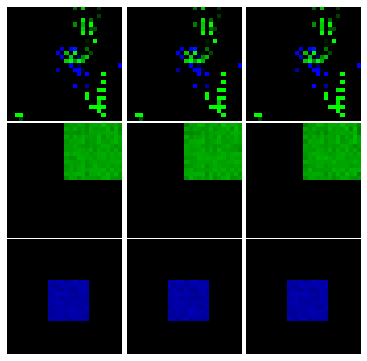

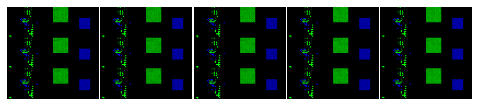

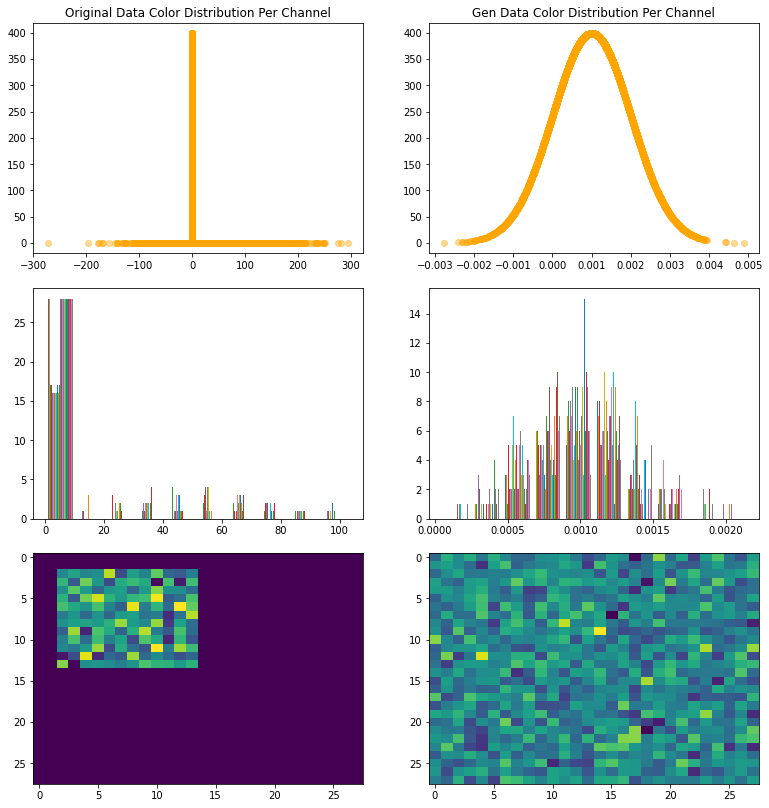

Time for epoch 4999 is 4.047929048538208 sec


'\n309148.\n\n'

In [122]:
# With random weights initialization the accuracy on fake images is very high, due to low weights -> low weights output -> sigmoid -> 0 -> 0 is good for fake images.
# The discriminator won't learn how to classify real images, will just be resilient to the generaor -> from epoch 1 and on Accuracy on real images = 0
# Find measure of image quality - perhaps mean std per pixel in dataset and compute the probability of that

# Convert ln of loss in probability
# USE AVG/MAX POOLING for image smoothness

# Aggiungere grafico con le immagini generate e la probabilità assegnata dal dataset d'origine
# Fix the x axis of the graphs, otherwise thwy will look similar
# MODIFY ALSO DISCRIMINATOR
# Add avg pooling as last layer - to smooth images coming out of the generator

# The log loss when you have conditioning cannot be computed conditioned_image vs entire original dataset. It won't match - > If the generated seed distribution is not equal to the dataset intrinsic distribution of classes
# LOG TO TENSORBOARD ALSO DISTRIBUTIONs DISPLAYED BY MATPLOT
# CHECK DISTRIBUTION ON NORMALIZED OR NOT IMAGES
# CHANGE HOW TO GEN EXTRA INPUTS OR BATCH WITH DIFFERENT SIZE FUCK UP

# Save to tensorboard THE DISTO PLOTS!!
# Plot the distribution as if 20x20 images
# Find a way to Introduce the variance in the image
# Add graphs of losses?

# image sum log loss uses the mean of the generated images to calculate the probability of that to be sampled on the real dist
# -> calculate the distance between the real dist and the generated image dist
# Rivedere se usare sum log loss o direttamente mean log loss (per pixel/channel etc)

# Add a part of the architecture trained on IQA dataset to help producing good results

## CReare dataset di immaggini con solo rosso, magari distribuzione a forma di quadrato e vedere
## Se la GAN riesce a ricreare la distribuzione in uscita
# od anche blue ve

rlib()
EPOCHS = 5000
#valid_dataset
image_save_path = path_to_TrackGAN + 'Generated Images/' + model_name +'/'

# Check if a checkpoint exists
if checkpoint_manager.latest_checkpoint:
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
  _ = checkpoint.restore(checkpoint_manager.latest_checkpoint)




train_asses.train(training_dataset, EPOCHS, valid_dataset= None, starting_epoch= checkpoint.step.numpy() ,
                  generator= generator, discriminator= discriminator, generator_optimizer= generator_optimizer, discriminator_optimizer= discriminator_optimizer,
                  generator_loss= generator_loss, discriminator_loss= discriminator_loss, noise_dim= noise_dim, summary_writer= summary_writer, gen_seed= [ noise_seed, target_seed],
                  checkpoint_manager= checkpoint_manager, distributions= distributions, model_name= model_name, DEBUG= False, BATCH_SIZE= BATCH_SIZE,
                  image_save_path= image_save_path, custom_gan_metrics= custom_gan_metrics )


'''
309148.

'''

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
if checkpoint_manager.latest_checkpoint:
  print("Restored from {}".format(checkpoint_manager.latest_checkpoint))
  _ = checkpoint.restore(checkpoint_manager.latest_checkpoint)
  #checkpoint_to_restore = '/content/drive/My Drive/Colab Notebooks/TrackGAN/training_checkpoints/ConditionedGAN Shrinked/tf_ckpts-146'
  #_ = checkpoint.restore(checkpoint_to_restore)



Restored from /content/drive/My Drive/Colab Notebooks/TrackGAN/training_checkpoints/ConditionedGAN G 356k-275k/tf_ckpts-43


Target :  0


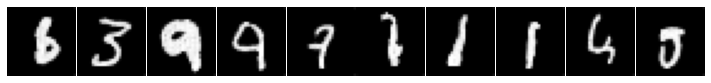

Target :  1


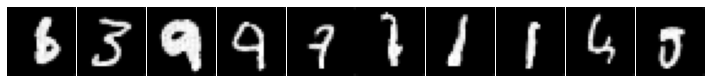

Target :  2


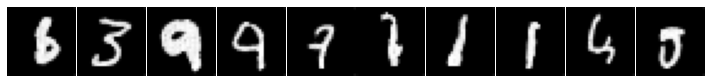

Target :  3


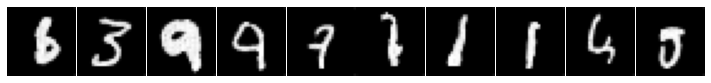

In [ ]:
num_examples_to_generate = 10

noise_sample = train_asses.generate_noise([ num_examples_to_generate, noise_dim])

model_name = "Prediction CGAN"

for i in range(0,4):
  #Set the target index to 1
  sample_target = [0,0,0,0,0,0,0,0,0,0]
  sample_target[i] = 1
  print("Target : " , i)

  # Batch data
  batch_target = np.array([ sample_target ]*num_examples_to_generate)

  generated_images = generator([noise_sample , batch_target],training= False)
  image_utils.display_multiple_image(image_utils.denormalize_images(generated_images) ,  size = (900,900), inline=True)


In [ ]:
image_path = path_to_TrackGAN + 'Generated Images/' + model_name +'/'

anim_file = path_to_TrackGAN + 'Generated Images/' + model_name + '.gif'

image_utils.generate_GIF(image_path, anim_file)

In [ ]:
#!pip install  git+https://github.com/tensorflow/docs
#import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)